# Cáculos Modelagem/Projeto Controlador 

A modelagem envolve o repositório MOTORDC_SPWM (ver readme.md). \
O controlador será testado neste repositório, que serviu de base para o TCC.pdf, aqui também deixado.

In [62]:
import numpy as np
import matplotlib.pyplot as plt
import control.matlab as cl
import pandas as pd

plt.rcParams['text.usetex'] = True
s = cl.tf('s')

In [63]:
'''lê csv e processa colunas do ensaio (frequencias)'''
df = pd.read_csv("data1_ajustado.csv")
f= np.array(df['f'].values)
Vo= np.array(df['Vo'].values)/1000
Vi= np.array(df['Vi'].values)
ang= np.array(df['Fase'].values)
Vi = Vi/700*0.21 

In [64]:
"""lê o segundo csv, processa colunas do ensaio (degrau) """
#fatia os dados, apenas um intervalo já é suficiente
df = pd.read_csv("degrau.csv")
t= np.array(df['t'].values)[1080:2000:]
t= t -t[0]
Vin= np.array(df['Vin'].values)[1080:2000:]
Io= np.array((df['Io'].values))[1080:2000:]
Io = (Io*2 -1.36)*-1
# plt.figure(1)
# plt.plot(t,Io)
# plt.ylabel('$I_o(A)$',fontsize=20)
# plt.xlabel('$t(s)$',fontsize=20)
# plt.savefig('step.pdf', bbox_inches='tight')


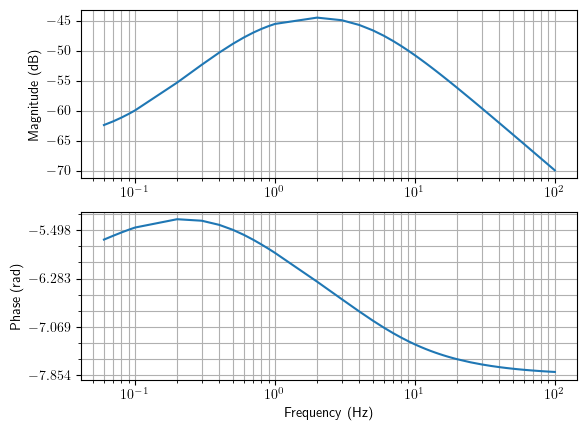

In [65]:
"""geração do diagrama de bode"""
w = 2*np.pi*np.linspace(0.06,100,50)
mag, phi , f= cl.bode(0.2*(s+0.433)/((s+4.5*2*np.pi)*(s+0.85*2*np.pi)) , f*2*np.pi, Hz = True, deg = False)
phi = np.rad2deg(phi) +360
f = f/(2*np.pi)

### Comparando resultados do método Resposta frequência com modelo Matlab

1) Bode

Text(0.5, 0, '$\\log{f}(Hz)$')

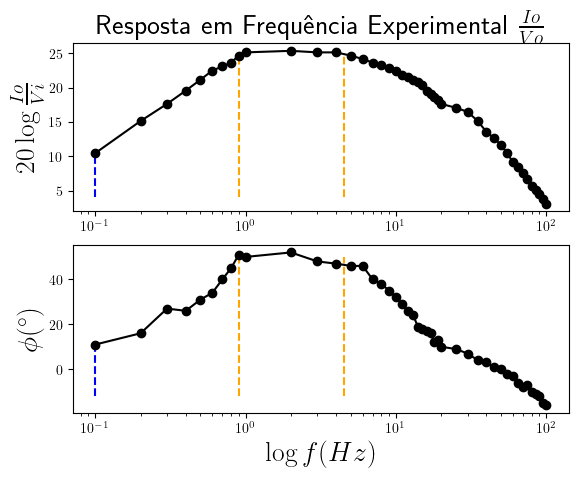

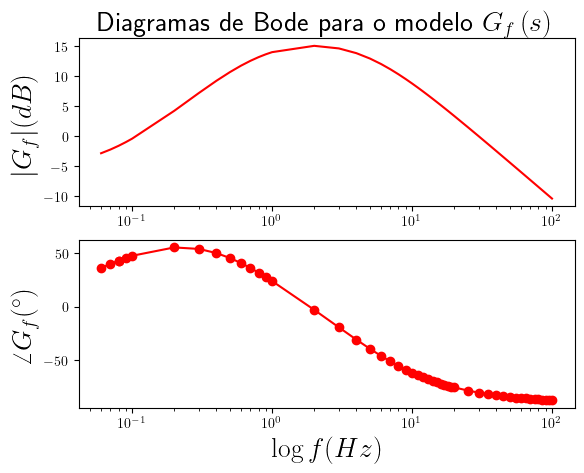

In [66]:
plt.figure(1)
plt.subplot(2,1,1)
plt.title("Resposta em Frequência Experimental $\\frac{Io}{Vo}$", fontsize =20)
plt.vlines((0.9,4.5),4,25, linestyles='dashed', colors= 'orange')
plt.vlines((0.1),4,10, linestyles='dashed',colors='blue')
plt.semilogx(f,20*np.log10(Vo/Vi), color='black',marker ='o')
plt.ylabel('$20 \\log{\\frac{Io}{Vi}}$',fontsize=20)
plt.subplot(2,1,2)
plt.vlines((0.9,4.5),-12,50, linestyles='dashed', colors= 'orange')
plt.vlines((0.1),-12,10, linestyles='dashed',colors='blue')
plt.semilogx(f[5:],ang[5:], color='black',marker ='o', label= 'obtido experimentalmente')
plt.ylabel('$\\phi(^\\circ)$',fontsize=20)
plt.xlabel('$\\log{f}(Hz)$',fontsize=20)
# plt.savefig('bode.pdf', bbox_inches='tight')

plt.figure(2)
plt.subplot(2,1,1)
plt.semilogx(f,59.6+20*np.log10(mag), color= 'red')
plt.title("Diagramas de Bode para o modelo $G_f \\left(s\\right)$", fontsize =20)
plt.ylabel('$|G_f|(dB)$',fontsize=20)
plt.subplot(2,1,2)
plt.semilogx(f,phi, color='red',marker ='o')
plt.ylabel('$\\angle G_f(^\\circ)$',fontsize=20)
plt.xlabel('$\\log{f}(Hz)$',fontsize=20)
# plt.savefig('bodeC.pdf', bbox_inches='tight')

2) Degrau \
   $G_i$: Resposta via toolbox ident (degrau aplicado Vin=600mV) \
   $G_d$: Resposta via modelo (degrau aplicado Vin =600mV -> Vin = 0.194 =duty )

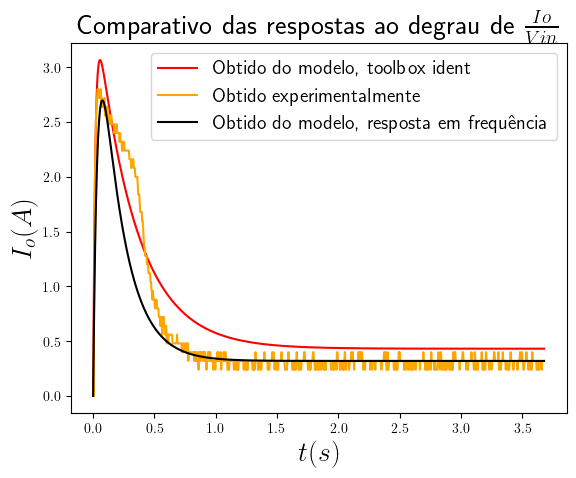

In [67]:
Gi = 1050*(s+0.38)/(s**2 + 60.12*s + 179.3)
Gf = 566*(s+0.44)/((s+4.5*2*np.pi)*(s+0.85*2*np.pi))
I, t = cl.step(Gi,t)
If , t = cl.step(Gf, t)
# plt.figure(3)
# plt.plot(t,Io)
# plt.ylabel('$I_o(A)$',fontsize=20)
# plt.xlabel('$t(s)$',fontsize=20)
# plt.savefig('step.pdf', bbox_inches='tight')
plt.figure(4)
plt.plot(t,I*0.194,label = 'Obtido do modelo, toolbox ident', color = 'red')
plt.plot(t,Io,label = 'Obtido experimentalmente' , color = 'orange')
plt.plot(t,If*0.194, label='Obtido do modelo, resposta em frequência ', color ="black",)
plt.legend(fontsize=14)
plt.title('Comparativo das respostas ao degrau de $\\frac{Io}{Vin}$ ',fontsize=20)
plt.ylabel('$I_o(A)$',fontsize=20)
plt.xlabel('$t(s)$',fontsize=20)
# plt.savefig('stepsss.pdf', bbox_inches='tight')
plt.show()

3) Desempenhos

In [68]:
Io = Io +0.05
I += 0.05
If+=0.05
# offset dado para evitar problema de div por zero
err_exp = np.sum((Io - If*0.194)/Io)*100/len(Io)
err_ident = np.sum((Io-I*0.194)/Io)*100/len(Io) 
print(f'\nErro MAPE, via experimental: ', abs(err_exp), '%')
print(f'\nErro MAPE, via ident: ', abs(err_ident), '%')


Erro MAPE, via experimental:  9.579825139165026 %

Erro MAPE, via ident:  30.027300696847735 %


### Projeto do controlador

Requisitos: 
- Resposta deve ter acomodação mais rápida que o sistema não controlado
- $\zeta > 0.5$ ( Overshoot pequeno)
  
Possíveis soluções, controlador PI:
- Cancelamento do polo dominante
- Cancelamento do polo irrelevante
  
Controlador C:
$$ C = \frac{s + p_2}{s}$$ 
Onde $p_2$ é um dos dois polos do sistema $G_f$ \
Transfer function: 
$$C = \frac{k_p}{s} \cdot (s + \frac{k_i}{s})$$

In [69]:
"""Buscando a estratégia de cancelar polo mais rápido em -4.5*2*np.pi"""
p2 =4.5*2*np.pi
kp =1
ki = kp*p2